$$
\textbf{Lógica Computacional: 2020/2021}\qquad
\textbf{Trabalho 1}\qquad
\scriptsize{Gilberto \, Cunha \quad Tomás \, Carneiro}
$$

# Problema 2

In [1]:
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from z3 import *

In [44]:
def draw_graph (graph):
    node_labels = {}
    for i in graph.nodes:
        if graph.nodes[i]["type"] == "xor":
            node_labels[i] = "$\oplus$"
        elif graph.nodes[i]["type"] == "sum":
            node_labels[i] = "$+$"
        elif graph.nodes[i]["type"] == "shift":
            node_labels[i] = "$\gg_{" + str(graph.nodes[i]["r"]) + "}$"
        else:
            j = [z for k,z in graph.edges if k==i]
            if len(j) == 0:
                node_labels[i] = "out"
            else:
                node_labels[i] = "in"
            
    edge_labels = {(i,j): graph.edges[i,j]["value"] for i,j in graph.edges if "value" in graph.edges[i,j]}
    for i,j in graph.edges:
        if "value" not in graph.edges[i,j]:
            edge_labels[i,j] = "?"
            
    node_colors = []
    for i in graph.nodes:
        if graph.nodes[i]["type"] == "input":
            node_colors.append("green")
        elif graph.nodes[i]["type"] == "output":
            node_colors.append("red")
        else:
            node_colors.append("orange")
            
    f = plt.figure(figsize=(12, 12))
    plt.title("Graph")
    pos = nx.nx_pydot.graphviz_layout(graph)
    pos = nx.nx_pydot.graphviz_layout(graph, prog="dot")
    nx.draw(graph, font_size=10, pos=pos, labels=node_labels, node_size=[600 for _ in graph.nodes], node_color=node_colors)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)
    plt.show()

Os dados são consistentes


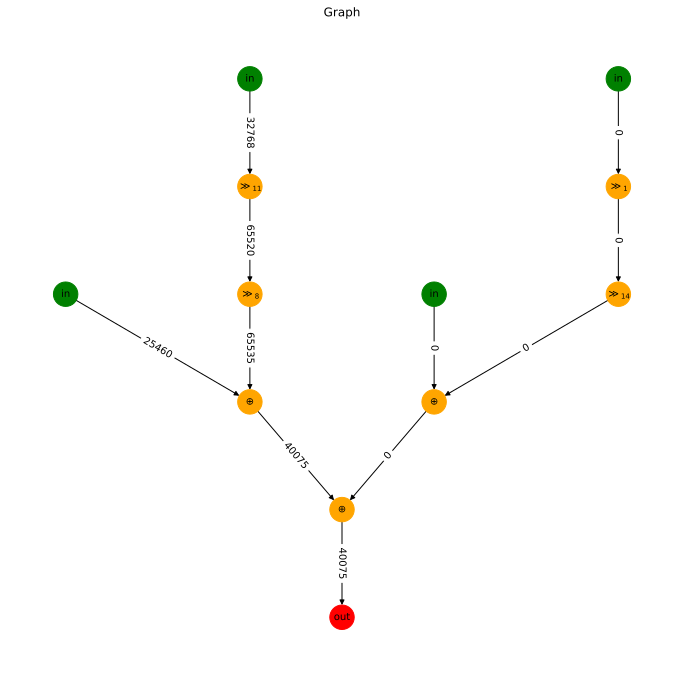

In [46]:
def random_binary_tree(N):
    
    # Criar output e primeiro nodo da árvore
    graph = nx.DiGraph()
    graph.add_nodes_from([0, 1])
    graph.add_edges_from([(0, 1)])
    
    # Sempre que ainda puder adicionar um novo nodo
    while len(graph.nodes) < N:
        # Encontrar as folhas da árvore
        leaves = [i for i in graph.nodes if len(list(graph.neighbors(i)))==0]
        np.random.shuffle(leaves)
        
        # Colocar elemento na folha da àrvore
        for i in leaves:
            n = len(graph.nodes)
            if min(2, N-n) == 0:
                pass
            else:
                num_nodes = 2
                nodes = [j for j in range(n, n+num_nodes)]
                edges = [(i, j) for j in nodes]
                graph.add_nodes_from(nodes)
                graph.add_edges_from(edges)
                
    assert len(graph.nodes) == N            
    
    return graph

def random_graph(N, M, gamma, n):
    # Há 1 nodo de output, N de input e N-1 binários
    bin_gates = [i for i in range(1, N)]
    graph = random_binary_tree(2*N)
    graph.nodes[0]["type"] = "output"
    
    # Adicionar o tipo às gates binárias
    num_sum = 0
    np.random.shuffle(bin_gates)
    bin_ops = ["sum", "xor"]
    for i in bin_gates:
        if (num_sum+1)/M < gamma:
            op = bin_ops[np.random.randint(0,2)]
        else:
            op = "xor"
        graph.nodes[i]["type"] = op
        
    # Adicionar o tipo às gates de input e output
    for i in graph.nodes:
        if len(list(graph.neighbors(i))) == 0:
            graph.nodes[i]["type"] = "input"
    
    # Adicionar os nodos de shift aritmético
    for i in range(2*N, N+M+1):
        j, k = list(graph.edges)[np.random.randint(len(graph.edges))]
        graph.add_nodes_from([i])
        graph.nodes[i]["type"] = "shift"
        graph.nodes[i]["r"] = np.random.randint(1, n)
        graph.remove_edges_from([(j, k)])
        graph.add_edges_from([(j, i), (i, k)])
        
    # Adicionar o valor da aresta de output
    j = [j for i,j in graph.edges if i==0][0]
    graph.edges[0,j]["value"] = BitVecVal(np.random.randint(2**n), n)
        
    graph = nx.DiGraph.reverse(graph)
    # Adicionar valores aleatórios aos nodos de output e soma
    for i in graph.nodes:
        if graph.nodes[i]["type"] == "sum":
            value = np.random.randint(2**n)
            j = list(graph.neighbors(i))[0]
            graph.edges[i,j]["value"] = BitVecVal(value, n)
        
    return graph
            
N, M, gamma, n = 4, 7, 0.1, 16
G = random_graph(N, M, gamma, n)
# draw_graph(G)

H = nx.DiGraph.reverse(G)
solver = Solver()

B = {}
for i, j in H.edges:
    if "value" not in H.edges[i,j]:
        B[i,j] = BitVec(f"{i},{j}", n)
    else:
        B[i,j] = H.edges[i,j]["value"]
    

for i, j in H.edges:
    out = B[i,j]
    if H.nodes[j]["type"] == "xor":
        nbr1, nbr2 = list(H.neighbors(j))
        a, b = B[j, nbr1], B[j, nbr2]
        solver.add (a^b == out)
    elif H.nodes[j]["type"] == "shift":
        nbr = list(H.neighbors(j))[0]
        a = B[j, nbr]
        solver.add (a >> H.nodes[j]["r"] == out)
    elif H.nodes[j]["type"] == "sum":
        nbr1, nbr2 = list(H.neighbors(j))
        a, b = B[j, nbr1], B[j, nbr2]
        solver.add (a+b == out, a+b < 2**16)
        
if solver.check() == sat:
    print ("Os dados são consistentes")
    m = solver.model()
    for i,j in B:
        if m[B[i,j]] != None:
            H.edges[i,j]["value"] = m[B[i,j]]
        
    G = nx.DiGraph.reverse(H)
    draw_graph(G)
else:
    print ("Os dados não são consistentes")

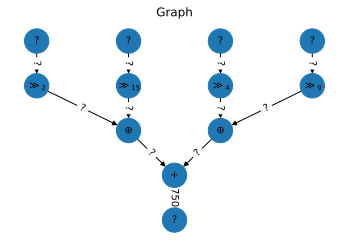

In [165]:
n = 16

G = nx.DiGraph()
G.add_nodes_from([i for i in range(12)])
G.add_edges_from([(1, 0), (2, 1), (3, 1), (6, 3), (4, 2), (5, 2), (7, 3), (8, 7), (9, 5), (10, 4), (11, 6)])

G.nodes[0]["type"] = "output"
G.edges[1,0]["value"] = BitVecVal(np.random.randint(2**16), n)
# G.edges[1,0]["value"] = 10
for i in [8, 9, 10, 11]:
    G.nodes[i]["type"] = "input"
for i in [2, 3]:
    G.nodes[i]["type"] = "xor"
for i in [4, 5, 6, 7]:
    G.nodes[i]["type"] = "shift"
    G.nodes[i]["r"] = np.random.randint(1, 16)
G.nodes[1]["type"] = "sum"
G.nodes[1]["value"] = BitVecVal(10, n)
    
draw_graph(G)

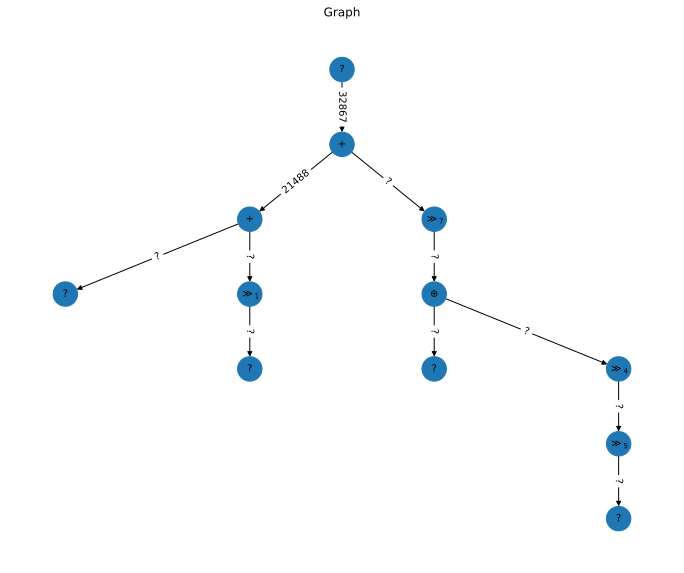

In [27]:
H = nx.DiGraph.reverse(G)
draw_graph(H)

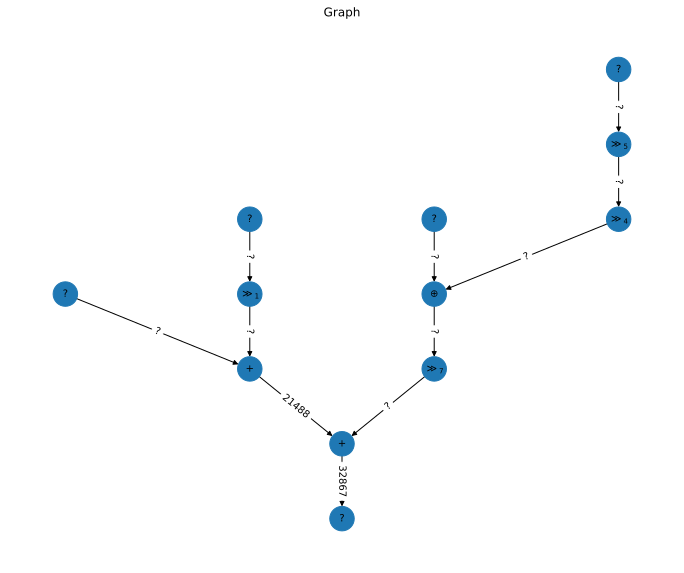

In [28]:
solver = Solver()

B = {}
for i, j in H.edges:
    if "value" not in H.edges[i,j]:
        B[i,j] = BitVec(f"{i},{j}", n)
    else:
        B[i,j] = H.edges[i,j]["value"]
    

for i, j in H.edges:
    out = B[i,j]
    if H.nodes[j]["type"] == "xor":
        nbr1, nbr2 = list(H.neighbors(j))
        a, b = B[j, nbr1], B[j, nbr2]
        solver.add (a^b == out)
    elif H.nodes[j]["type"] == "shift":
        nbr = list(H.neighbors(j))[0]
        a = B[j, nbr]
        solver.add (a >> H.nodes[j]["r"] == out)
    elif H.nodes[j]["type"] == "sum":
        nbr1, nbr2 = list(H.neighbors(j))
        a, b = B[j, nbr1], B[j, nbr2]
        solver.add (a+b == out, a+b < 2**16)
        
if solver.check() == sat:
    m = solver.model()
    for i,j in B:
        if m[B[i,j]] != None:
            H.edges[i,j]["value"] = m[B[i,j]]
        
G = nx.DiGraph.reverse(H)
draw_graph(G)